In [1]:
from __future__ import print_function
import json

import numpy as np
from theano import sandbox
import matplotlib.pyplot as plt

from ddpg import Actor, Critic
from naf.priority_buffer import PriorityBuffer
from environment import Environment, WIN, LOSE, NEUTRAL

Using Theano backend.


In [2]:
MAX_DIST = 0.01
#sandbox.cuda.use('gpu0')
env = Environment(MAX_DIST, 'pushing-fixed-goal')

In [3]:
critic = Critic(env.get_state().shape[1], 2)
critic_target = Critic(env.get_state().shape[1], 2)
critic_target.clone_params(critic)

actor = Actor(env.get_state().shape[1], 2, critic, output_scaling=MAX_DIST)
actor_target = Actor(env.get_state().shape[1], 2, critic_target, output_scaling=MAX_DIST)
actor_target.clone_params(actor)

In [4]:
def return_average(env, actor, gamma=0.99):
    rewards = []
    for trial in range(32):
        np.random.seed(trial)
        env.reset()
        n_steps = 256
        return_ = 0.0
        for i in range(n_steps):
            mu = actor.predict(env.get_state())
            _, r, _ = env.interact(*mu.flatten())
            return_ += gamma ** i * r
        rewards.append(return_)
    return np.mean(rewards), np.std(rewards)

return_average(env, actor)

(-59.644559357547266, 26.775474416421741)

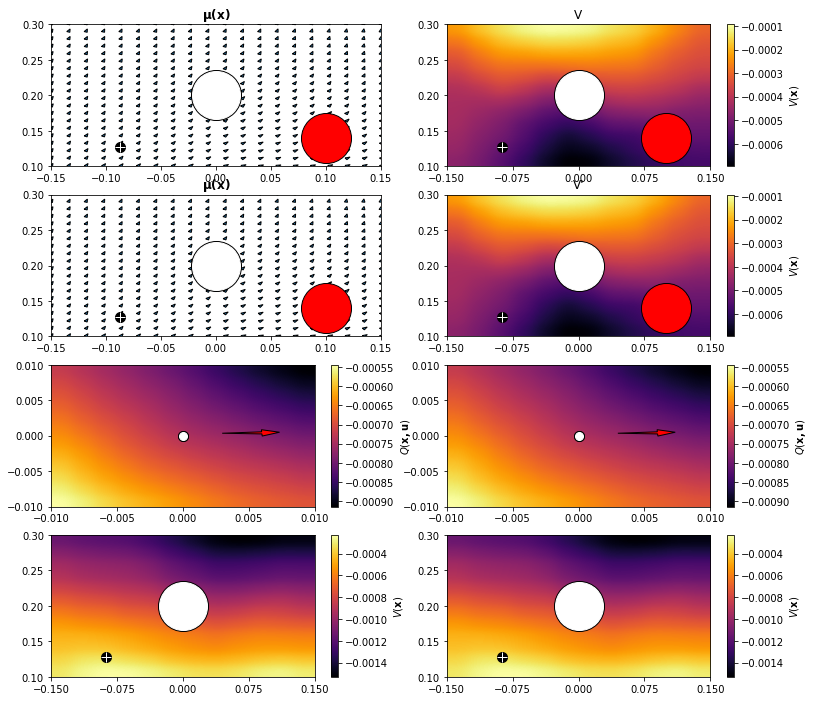

In [5]:
def plot_q(actor, critic, env):
    xs = np.linspace(env.min_x, env.max_x, 12)
    ys = np.linspace(env.min_y, env.max_y, 12)
    xss, yss = np.meshgrid(xs, ys)
    zss = np.zeros(xss.shape)
    X = env.get_state()
    for i, x in enumerate(xs):
        for j, y in enumerate(ys):
            zss[len(ys) - j - 1, i] = critic.predict(
                X,
                np.array([[x, y]])
            )[0, 0]
    plt.imshow(zss, cmap='inferno', interpolation='gaussian', aspect='auto',
               extent=[-env.max_dist, env.max_dist, -env.max_dist, env.max_dist])

    
    plt.plot(0.0, 0.0, 'ko', markersize=10)
    plt.plot(0.0, 0.0, 'w+', markersize=10)
    
    mu = actor.predict(env.get_state())
    dx, dy = mu[0, :]
    plt.plot(dx, dy, 'ko', markersize=10)
    plt.plot(dx, dy, 'wo', markersize=8)
    
    d = np.array([env.circle.x - env.eef_x, env.circle.y - env.eef_y])
    d /= np.linalg.norm(d)
    plt.arrow(0.003 * d[0], 0.003 * d[1], 0.003 * d[0], 0.003 * d[1], width=0.0003, facecolor='r')
    
    plt.xticks(np.linspace(-0.01, 0.01, 5))
    plt.yticks(np.linspace(0.01, -0.01, 5))
    plt.colorbar().set_label('$Q(\mathbf{x, u})$')


def plot_pi(nn, env, eef=None):
    for x in np.linspace(env.min_x, env.max_x, 20):
        for y in np.linspace(env.min_y, env.max_y, 20):
            env.eef_x = x
            env.eef_y = y
            dx, dy = nn.predict(env.get_state())[0, :]
            plt.arrow(x, y, dx, dy)
    plt.plot(env.goal_x, env.goal_y, 'ko', markersize=50)
    plt.plot(env.goal_x, env.goal_y, 'wo', markersize=48)
    if env.mode.startswith('pushing'):
        plt.plot(env.circle.x, env.circle.y, 'ko', markersize=50)
        plt.plot(env.circle.x, env.circle.y, 'ro', markersize=48)
    
    #eef
    if eef is not None:
        plt.plot(eef[0], eef[1], 'ko', markersize=10)
        plt.plot(eef[0], eef[1], 'w+', markersize=10)
    
    plt.title('$\mathbf{\mu(x)}$')
    plt.xlim(env.min_x, env.max_x)
    plt.ylim(env.min_y, env.max_y)
    
def plot_v(actor, critic, env, eef=None):
    xs = np.linspace(env.min_x, env.max_x, 12)
    ys = np.linspace(env.min_y, env.max_y, 12)
    xss, yss = np.meshgrid(xs, ys)
    zss = np.zeros(xss.shape)
    for i, x in enumerate(xs):
        for j, y in enumerate(ys):
            env.eef_x = x
            env.eef_y = y
            zss[len(ys) - j - 1, i] = critic.predict(
                env.get_state(),
                actor.predict(
                    env.get_state()
                )
            )[0, 0]
    plt.imshow(zss, cmap='inferno', interpolation='gaussian', aspect='auto',
               extent=[env.min_x, env.max_x, env.min_y, env.max_y])
    plt.plot(env.goal_x, env.goal_y, 'ko', markersize=50)
    plt.plot(env.goal_x, env.goal_y, 'wo', markersize=48)
    if env.mode.startswith('pushing'):
        plt.plot(env.circle.x, env.circle.y, 'ko', markersize=50)
        plt.plot(env.circle.x, env.circle.y, 'ro', markersize=48)

    #eef
    if eef is not None:
        plt.plot(eef[0], eef[1], 'ko', markersize=10)
        plt.plot(eef[0], eef[1], 'w+', markersize=10)

    plt.xticks(np.linspace(env.min_x, env.max_x, 5))
    plt.yticks(np.linspace(env.min_y, env.max_y, 5))
    plt.colorbar().set_label('$V(\mathbf{x})$')
    

def plot_v_over_circle_positions(actor, critic, env, eef=None):
    xs = np.linspace(env.min_x, env.max_x, 12)
    ys = np.linspace(env.min_y, env.max_y, 12)
    xss, yss = np.meshgrid(xs, ys)
    zss = np.zeros(xss.shape)
    for i, x in enumerate(xs):
        for j, y in enumerate(ys):
            env.circle.x = x
            env.circle.y = y
            zss[len(ys) - j - 1, i] = critic.predict(
                env.get_state(),
                actor.predict(
                    env.get_state()
                )
            )[0, 0]
    plt.imshow(zss, cmap='inferno', interpolation='gaussian', aspect='auto',
               extent=[env.min_x, env.max_x, env.min_y, env.max_y])
    plt.plot(env.goal_x, env.goal_y, 'ko', markersize=50)
    plt.plot(env.goal_x, env.goal_y, 'wo', markersize=48)

    #eef
    if eef is not None:
        plt.plot(eef[0], eef[1], 'ko', markersize=10)
        plt.plot(eef[0], eef[1], 'w+', markersize=10)

    plt.xticks(np.linspace(env.min_x, env.max_x, 5))
    plt.yticks(np.linspace(env.min_y, env.max_y, 5))
    plt.colorbar().set_label('$V(\mathbf{x})$')


def plot_shebang(actor, critic, actor_target, critic_target, env):
    env.reset()
    eef_x, eef_y = env.eef_x, env.eef_y
    circle_x, circle_y = env.circle.x, env.circle.y
    plt.figure(figsize=(13, 12))
    plt.subplot(421)
    plot_pi(actor, env, eef=(eef_x, eef_y))
    plt.subplot(422)
    plt.title('V')
    plot_v(actor, critic, env, eef=(eef_x, eef_y))
    plt.subplot(423)
    plot_pi(actor_target, env, eef=(eef_x, eef_y))
    plt.subplot(424)
    plt.title('V\'')
    plot_v(actor_target, critic_target, env, eef=(eef_x, eef_y))
    plt.subplot(425)
    env.reset()
    env.eef_x = eef_x
    env.eef_y = eef_y
    env.circle.x = circle_x
    env.circle.y = circle_y
    plot_q(actor, critic, env)
    plt.subplot(426)
    plot_q(actor_target, critic_target, env)
    plt.subplot(427)
    env.reset()
    env.eef_x = eef_x
    env.eef_y = eef_y
    plot_v_over_circle_positions(actor, critic, env, eef=(eef_x, eef_y))
    plt.subplot(428)
    env.reset()
    env.eef_x = eef_x
    env.eef_y = eef_y
    plot_v_over_circle_positions(actor_target, critic_target, env, eef=(eef_x, eef_y))
    plt.show()
    
plot_shebang(actor, critic, actor_target, critic_target, env)
plt.show()

In [6]:
def sample_transition(env, priority_buffer, heuristic_prob=0.0):
    x1 = env.get_state()
    mu_rnd = MAX_DIST * np.tanh(75 * MAX_DIST * np.random.randn(2))
    mu_act = actor.predict(x1)[0, :]
    k = np.random.rand()
    mu = k * mu_rnd + (1 - k) * mu_act
    if np.random.rand() < heuristic_prob:
        mu = env.heuristic_move()
    end_state, reward, x2 = env.interact(*mu)
    priority_buffer.add({
        'x1': x1[0, :],
        'x2': x2[0, :],
        'reward': reward,
        'mu': mu,
        'end_state': end_state
    }).set_value(10.0)
    if end_state in [WIN, LOSE]:
        env.reset()

In [7]:
priority_buffer = PriorityBuffer(2 ** 20)

for i in range(512):
    sample_transition(env, priority_buffer, heuristic_prob=0.5)

In [ ]:
def sample_batch(X, Xp, Y, U, R, S, critic, actor_target, critic_target, priority_buffer, gamma=0.99):
    nodes = []
    for i in range(X.shape[0]):
        sample = priority_buffer.sample()
        nodes.append(sample)
        X[i, :] = sample.data['x1']
        Xp[i, :] = sample.data['x2']
        U[i, :] = sample.data['mu']
        R[i, :] = sample.data['reward']
        S[i, :] = sample.data['end_state']
    Y[:, :] = R + gamma * critic_target.predict(Xp, actor_target.predict(Xp))
    [node.set_value(abs(e[0]) + 1e-6) for node, e in zip(nodes, critic.predict(X, U) - Y)]
    Y[S == WIN] = R[S == WIN]

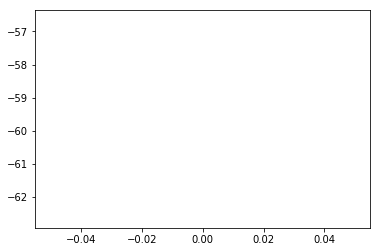

<PriorityBuffer object with 513 objects, max/mean value: 10.000/8.905>


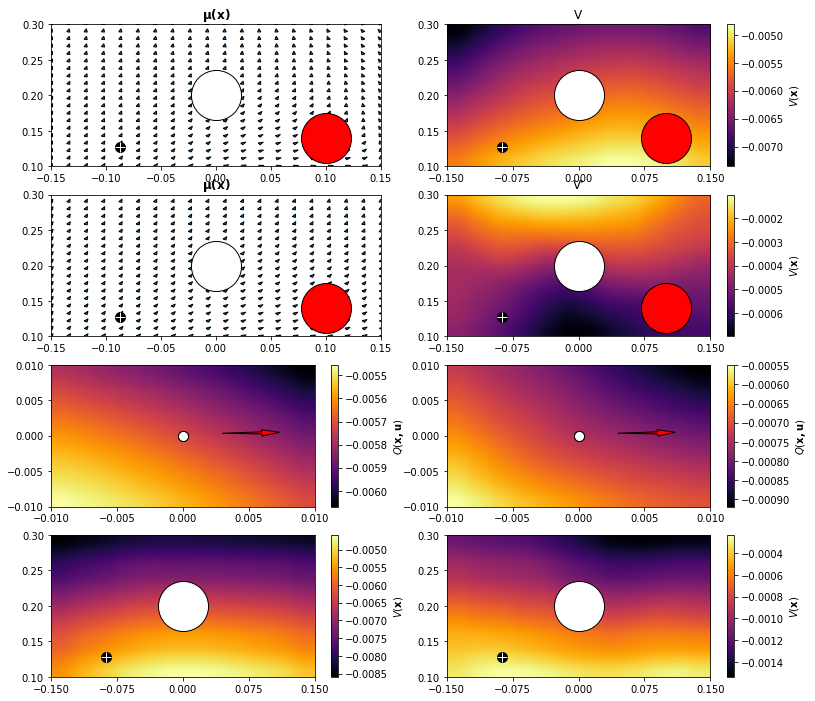

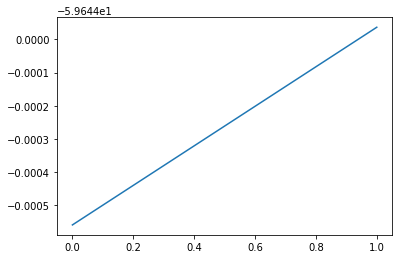

<PriorityBuffer object with 577 objects, max/mean value: 3.274/0.173>


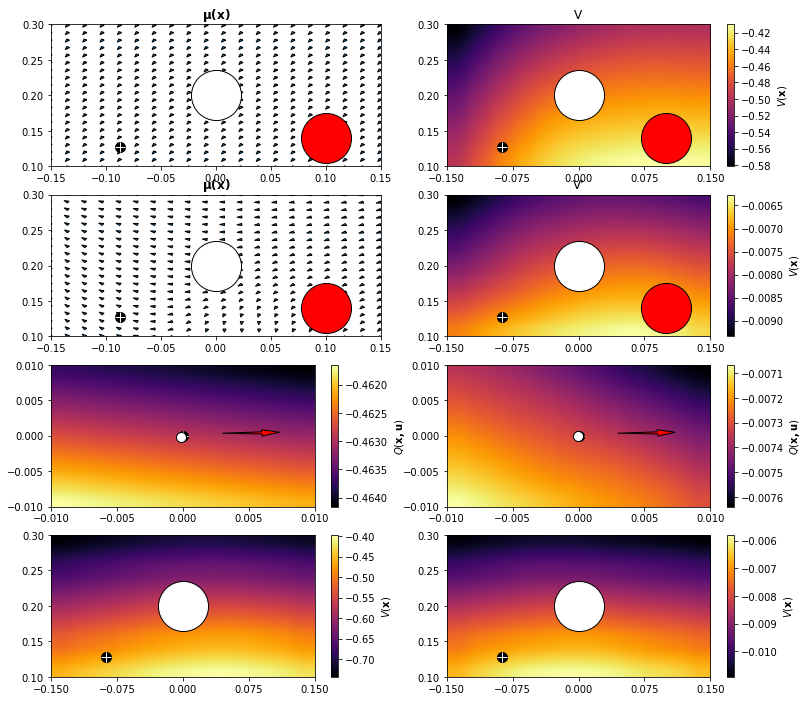

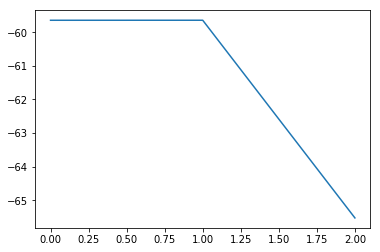

<PriorityBuffer object with 641 objects, max/mean value: 3.060/0.146>


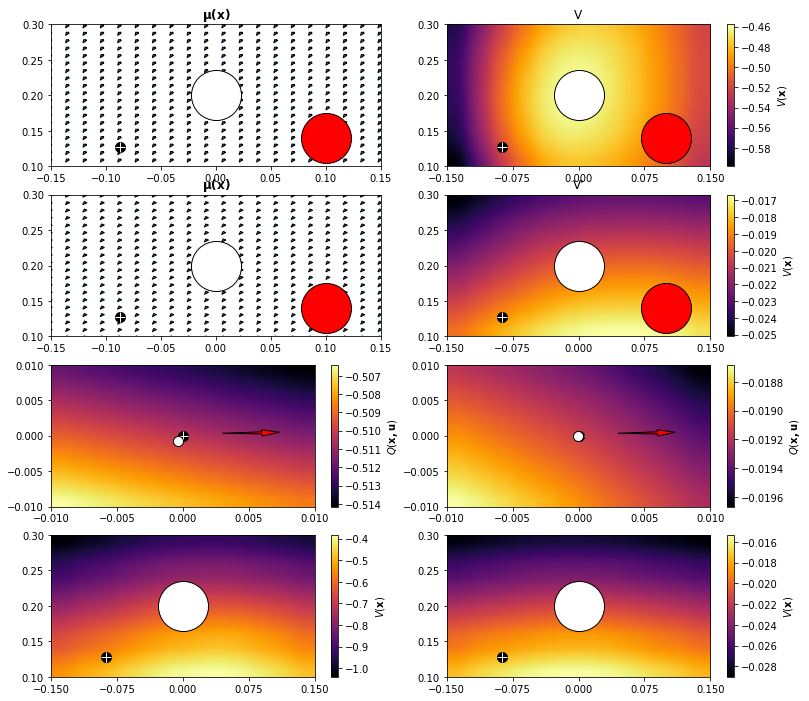

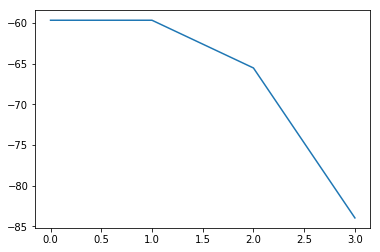

<PriorityBuffer object with 705 objects, max/mean value: 2.850/0.130>


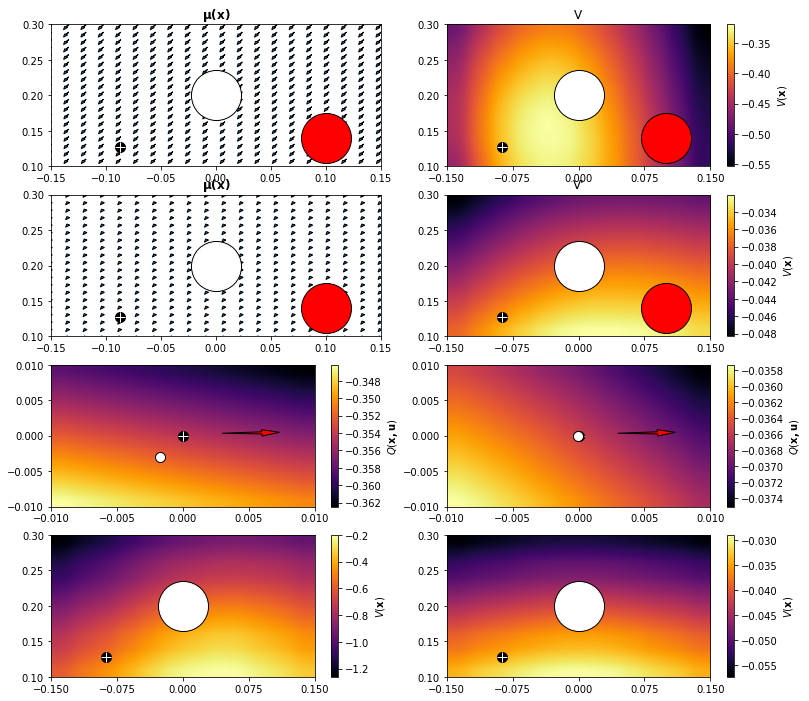

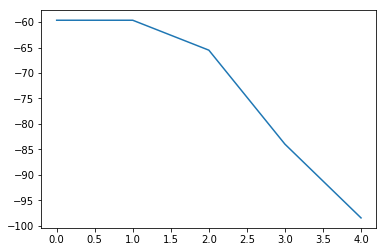

<PriorityBuffer object with 769 objects, max/mean value: 2.877/0.175>


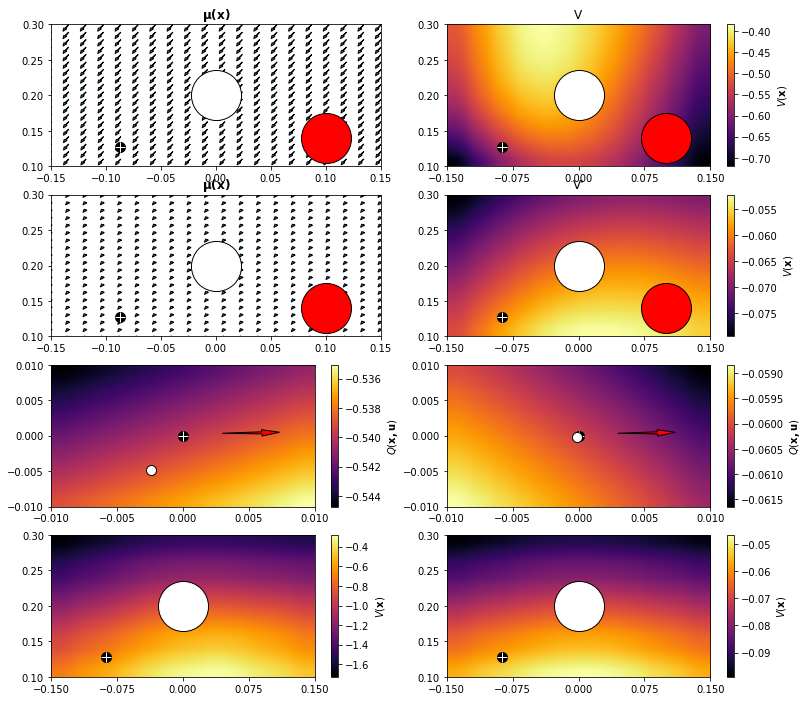

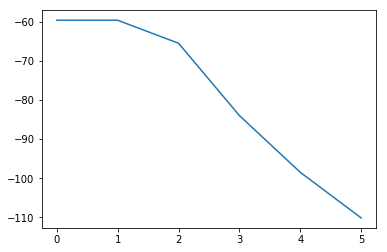

<PriorityBuffer object with 833 objects, max/mean value: 2.960/0.201>


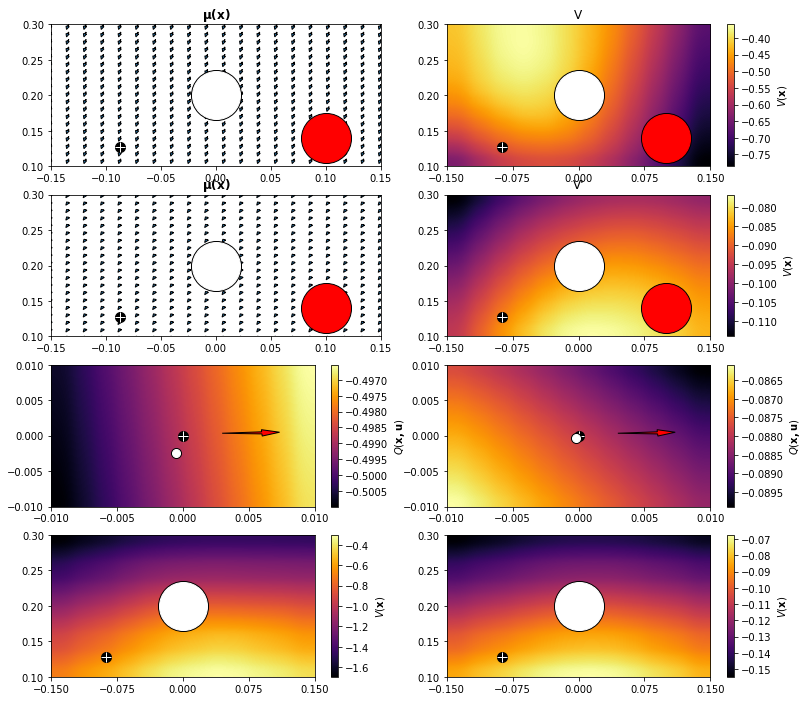

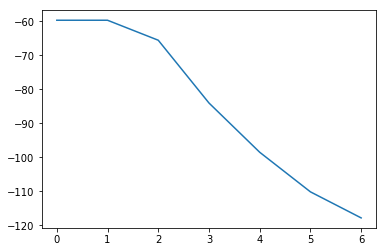

<PriorityBuffer object with 897 objects, max/mean value: 2.744/0.216>


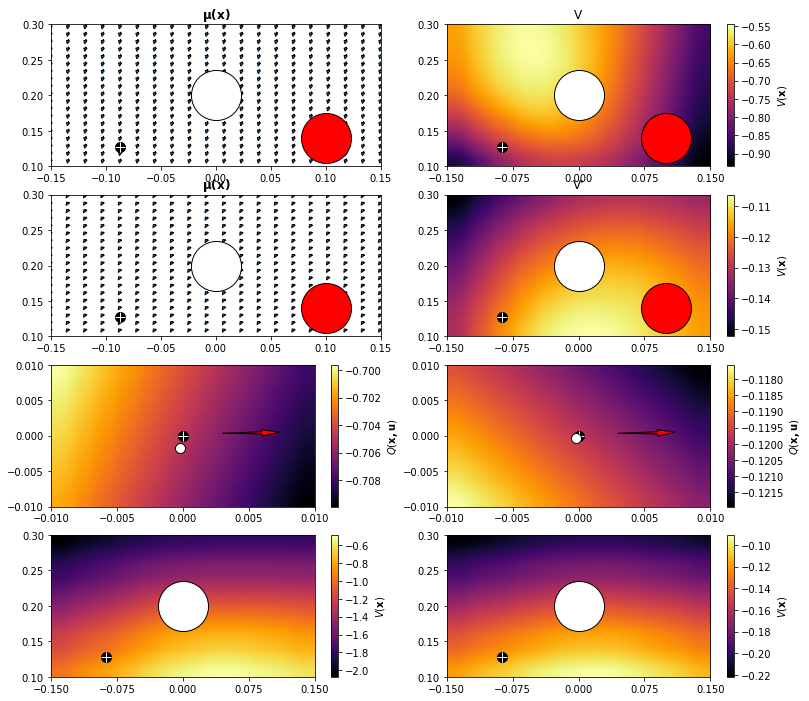

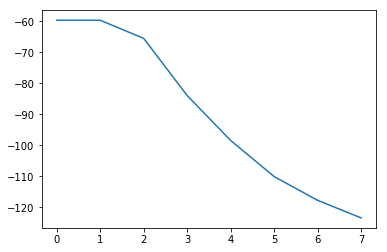

<PriorityBuffer object with 961 objects, max/mean value: 3.239/0.148>


In [ ]:
n_iterations = 2500000
batch_size = 64

X = np.zeros((batch_size, env.get_state().shape[1]))
Xp = np.zeros((batch_size, env.get_state().shape[1]))
U = np.zeros((batch_size, 2))
Y = np.zeros((batch_size, 1))
R = np.zeros((batch_size, 1))
S = np.zeros((batch_size, 1))

returns = []

iteration = 0
for iteration in range(iteration, n_iterations):
    sample_transition(env, priority_buffer)
    sample_batch(X, Xp, Y, U, R, S, critic, actor_target, critic_target, priority_buffer)
    critic.fit(X, U, Y)
    actor.fit(X)
    critic_target.soft_update(critic)
    actor_target.soft_update(actor)
    if iteration % 64 == 0:
        r_avg, r_std = return_average(env, actor_target)
        returns.append(r_avg)
        plt.plot(returns)
        with open('ddpg-returns.txt', 'w') as f:
            f.write(json.dumps(returns))
        plt.show()
        print(priority_buffer)
        plot_shebang(actor, critic, actor_target, critic_target, env)
        actor.save_params('actor_params.txt')
        actor_target.save_params('actor_target_params.txt')
        critic.save_params('critic_params.txt')
        critic_target.save_params('critic_target_params.txt')